In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets, mixture
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import h5py 

from evaluation import *
np.random.seed(0)

In [2]:
from sklearn.mixture import GaussianMixture

In [3]:
import scipy.io
mat = scipy.io.loadmat('/Users/OlgaKo/Desktop/one_plus_e/datasets/shuttle.mat')

X_data = mat["X"]
X_data = StandardScaler().fit_transform(X_data)

labels = mat["y"]

/Users/OlgaKo/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [4]:
from sklearn.model_selection import train_test_split
indx_train, indx_test = train_test_split(np.arange(len(labels), dtype='int32'), stratify=labels, test_size=0.5, random_state = 10)

In [5]:
y_train = labels[indx_train]
y_test = labels[indx_test]

X_train = X_data[indx_train]
X_test = X_data[indx_test]

In [6]:
X_good = X_train[np.where(y_train==0)[0]]

In [7]:
X_good.shape, X_data.shape

((22793, 9), (49097, 9))

In [8]:
gm = GaussianMixture(n_components=7, n_init=3, verbose=2)

In [9]:
gm.fit(X_good)

Initialization 0
  Iteration 0	 time lapse 0.15111s	 ll change inf
  Iteration 10	 time lapse 0.49483s	 ll change 0.00182
Initialization converged: True	 time lapse 0.69193s	 ll 10.24769
Initialization 1
  Iteration 0	 time lapse 0.12519s	 ll change inf
  Iteration 10	 time lapse 0.49535s	 ll change 0.02128
Initialization converged: True	 time lapse 1.06408s	 ll 12.17074
Initialization 2
  Iteration 0	 time lapse 0.13463s	 ll change inf
  Iteration 10	 time lapse 0.47743s	 ll change 0.05334
Initialization converged: True	 time lapse 0.95255s	 ll 12.18180


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=7, n_init=3, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=2,
        verbose_interval=10, warm_start=False, weights_init=None)

In [10]:
from scipy.stats import multivariate_normal

In [11]:
n_samples = X_good.shape[0]

In [12]:
gen = np.array(multivariate_normal.rvs(mean=gm.means_[0], cov=gm.covariances_[0], size=int(gm.weights_[0]*n_samples)))
for d in range(1,gm.n_components):
    gen=np.vstack((gen,multivariate_normal.rvs(mean=gm.means_[d], cov=gm.covariances_[d], size=int(gm.weights_[d]*n_samples))))
np.random.shuffle(gen)
gen = np.array(gen)

In [13]:
probabilities = np.empty((gm.n_components, gen.shape[0]))

In [14]:
for d in range(gm.n_components):
    probabilities[d] = multivariate_normal.pdf(gen, mean=gm.means_[d], 
                                                    cov=gm.covariances_[d], allow_singular=True)

In [15]:
gen.shape

(22790, 9)

In [16]:
maxprob = np.max(probabilities, axis = 0)
gen_w = 1./(maxprob+1e-1)

In [17]:
#indices = gen_w.argsort()[-50:][::-1]

In [18]:
#gen_w = np.delete(gen_w, indices)
#gen = np.delete(gen, indices, axis = 0)

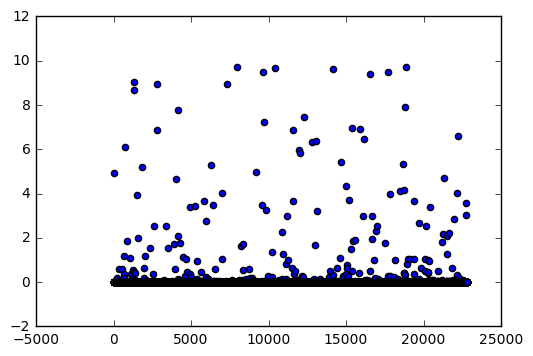

In [19]:
plt.scatter(np.arange(len(gen_w)), gen_w)
plt.show()

In [20]:
weights = np.ones((n_samples,1))

In [21]:
gen_w_normed = gen_w/np.sum(gen_w)*np.sum(weights)

In [22]:
gen_w_normed.sum(), np.sum(weights)

(22793.0, 22793.0)

In [23]:
y1 = np.zeros((n_samples,1))
y2 = np.ones((gen.shape[0],1))

In [24]:
X_mix = np.vstack((X_good, gen))

y_mix = np.vstack((y1, y2))

weights_mix = np.vstack((weights.reshape(-1,1), gen_w_normed.reshape(-1,1))).reshape(-1)

In [25]:
weights_mix.shape, y_mix.shape, X_mix.shape

((45583,), (45583, 1), (45583, 9))

In [26]:
import tensorflow as tf

s = tf.InteractiveSession()

import keras
from keras.models import Sequential
from keras import layers as L

Using TensorFlow backend.


In [27]:
net = Sequential()
net.add(L.Dense(80, input_shape=(9,), activation = 'relu'))
# net.add(L.Dropout(0.2))
# net.add(L.Dense(40, input_shape=(9,), activation = 'relu'))
net.add(L.Dense(1, activation='sigmoid'))

adam = keras.optimizers.Adam(lr=0.001)
net.compile(optimizer=adam, loss='binary_crossentropy')

In [28]:
history = net.fit(X_mix, y_mix, batch_size=64, epochs=50, validation_split = 0.1, verbose=1, shuffle=True, sample_weight=weights_mix)

Train on 41024 samples, validate on 4559 samples
Epoch 1/50
41024/41024 [==============================] - 2s - loss: 0.4835 - val_loss: 0.3336
Epoch 2/50
41024/41024 [==============================] - 2s - loss: 0.2833 - val_loss: 0.3128
Epoch 3/50
41024/41024 [==============================] - 2s - loss: 0.2137 - val_loss: 0.2492
Epoch 4/50
41024/41024 [==============================] - 2s - loss: 0.1765 - val_loss: 0.2367
Epoch 5/50
41024/41024 [==============================] - 2s - loss: 0.1536 - val_loss: 0.2185
Epoch 6/50
41024/41024 [==============================] - 2s - loss: 0.1325 - val_loss: 0.2496
Epoch 7/50
41024/41024 [==============================] - 2s - loss: 0.1247 - val_loss: 0.2146
Epoch 8/50
41024/41024 [==============================] - 2s - loss: 0.1132 - val_loss: 0.1807
Epoch 9/50
41024/41024 [==============================] - 2s - loss: 0.1035 - val_loss: 0.2178
Epoch 10/50
41024/41024 [==============================] - 2s - loss: 0.0964 - val_loss: 0.2089


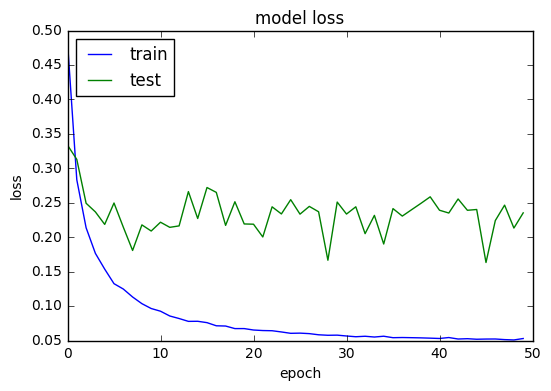

In [29]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
y_pred = net.predict(X_test, verbose=1)

24160/24549 [============================>.] - ETA: 0s

f1_score  0.979854504757
confusion_matrix 
[[22726    67]
 [    5  1751]]


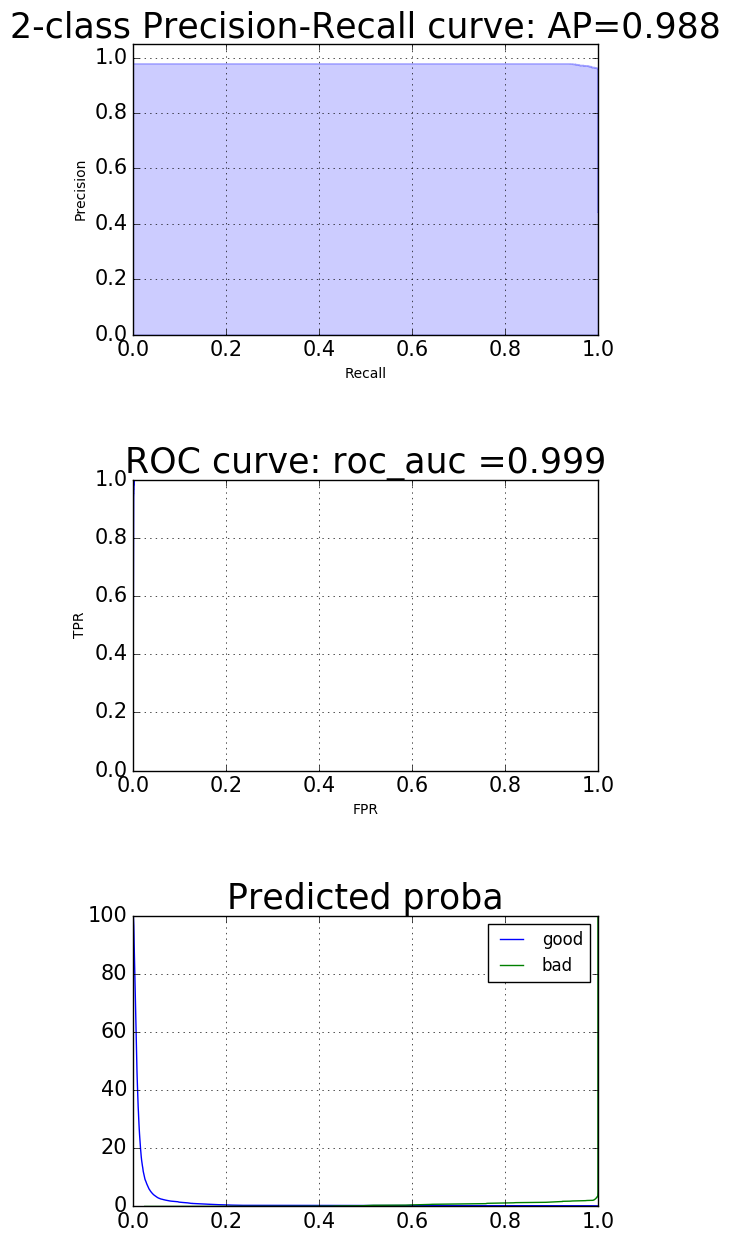

In [31]:
perfomance(y_test, y_pred)

## Classic methods

In [32]:
y_test_rescale = np.where(y_test == 0, -np.ones((y_test.shape)), np.ones((y_test.shape)))

One-Class SVM
recall_score  0.998291571754
precision_score  0.142647896493
f1_score  0.249626201495
confusion_matrix 
[[12257 10536]
 [    3  1753]]


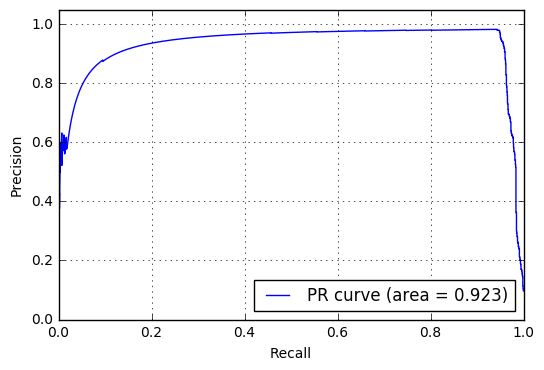

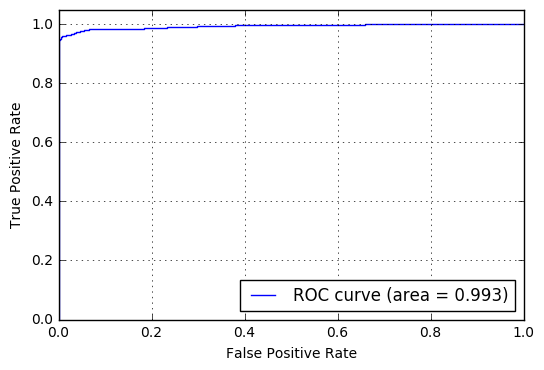

Isolation Forest
recall_score  0.961845102506
precision_score  0.955316742081
f1_score  0.958569807037
confusion_matrix 
[[22714    79]
 [   67  1689]]


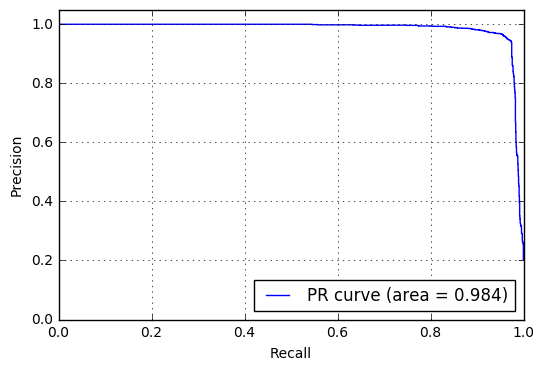

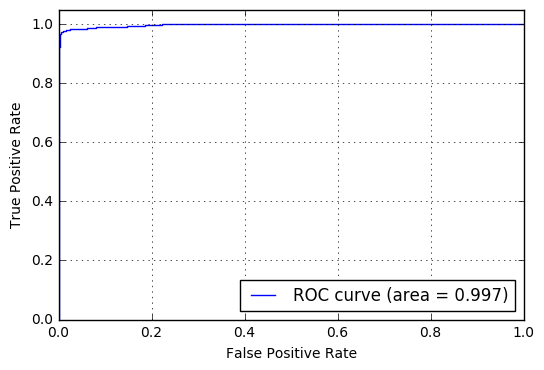

In [36]:
from sklearn import svm
from sklearn.ensemble import IsolationForest


classifiers_classic = {
    "One-Class SVM": svm.OneClassSVM(nu=0.005,
                                     kernel="rbf", gamma=1e-7),
    "Isolation Forest": IsolationForest(n_estimators=700,
                                        #max_samples=2000,
                                        contamination=0.005,
                                        random_state=10)}


for i, (clf_name, clf) in enumerate(classifiers_classic.items()):
        clf.fit(X_good)
        #scores_pred = clf.decision_function(X_test)
        y_pred = clf.predict(X_test)
        
        print (clf_name)
        print ("recall_score ",recall_score(y_test_rescale, np.round(-y_pred)))
        print ("precision_score ",precision_score(y_test_rescale, np.round(-y_pred)))
        print ("f1_score ",f1_score(y_test_rescale, np.round(-y_pred)))
        print ("confusion_matrix ")
        print (confusion_matrix(y_test_rescale, np.round(-y_pred)))
        


        Score = clf.decision_function(X_test)
        
        
        precision, recall, _ = precision_recall_curve(y_test_rescale, -Score)
        pr_auc = auc(recall, precision)

        plt.figure()
        plt.plot(recall, precision, label='PR curve (area = %0.3f)' % pr_auc)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()
        
        fpr, tpr, _ = roc_curve(y_test_rescale, -Score)
        roc_auc = auc(fpr, tpr)
        
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()
    